In [2]:
import pandas as pd
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
# No keys required for crypto data
client = CryptoHistoricalDataClient()

In [4]:
# Creating request object
tf = TimeFrame(amount=4, unit=TimeFrameUnit.Hour)

request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=tf,
  start=datetime(2025, 5, 1),
  end=datetime(2025, 5, 27)
)

In [6]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)
# btc_bars.df ist dein DataFrame (OHLCV-Daten)
btc_bars.df.to_csv('btc_bars_data.csv', index=True)

#btc_df = btc_bars.df

## Ab hier starten wenn Timeframe nicht verändert wird ##

In [9]:

btc_df = pd.read_csv('btc_bars_data.csv', parse_dates=['timestamp'], index_col='timestamp')


In [11]:
print(btc_df.head())

                            symbol        open          high         low  \
timestamp                                                                  
2025-05-01 00:00:00+00:00  BTC/USD  94146.5695  95027.560000  94146.5695   
2025-05-01 04:00:00+00:00  BTC/USD  94801.7470  95219.585000  94749.3635   
2025-05-01 08:00:00+00:00  BTC/USD  94998.4605  96402.900000  94968.0490   
2025-05-01 12:00:00+00:00  BTC/USD  96242.8360  97443.364467  95887.6440   
2025-05-01 16:00:00+00:00  BTC/USD  96973.9450  97417.664467  96468.3700   

                                close    volume  trade_count          vwap  
timestamp                                                                   
2025-05-01 00:00:00+00:00  94757.5900  0.003016         10.0  94792.264382  
2025-05-01 04:00:00+00:00  95059.2165  0.280592         17.0  94943.576939  
2025-05-01 08:00:00+00:00  96212.5820  0.297942         44.0  95905.852309  
2025-05-01 12:00:00+00:00  96915.2465  0.538422         61.0  96629.051249  
2025-

In [13]:
btc_df = btc_df.reset_index() 

In [106]:
def identify_market_structure(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['color'] = df.apply(lambda row: 'green' if row['close'] > row['open'] else 'red', axis=1)

    internal_structure = []
    external_structure = []

    last_internal_type = None
    last_external_type = None

    last_external_high = None
    last_external_low = None

    current_swing_high = None
    current_swing_low = None

    consecutive_red = 0
    consecutive_green = 0

    current_swing_direction = None  # Neu: Tracke aktuelle Swing Richtung ('up' oder 'down')

    for i in range(1, len(df)):
        curr = df.iloc[i]
        prev = df.iloc[i - 1]

        # Höchstes Hoch merken während Aufwärtsswing
        if current_swing_direction != 'down':
            if current_swing_high is None or curr['high'] > current_swing_high['high']:
                current_swing_high = curr

        # Tiefstes Tief merken während Abwärtsswing
        if current_swing_direction != 'up':
            if current_swing_low is None or curr['low'] < current_swing_low['low']:
                current_swing_low = curr

        # Farben zählen
        if curr['color'] == 'red':
            consecutive_red += 1
            consecutive_green = 0
        elif curr['color'] == 'green':
            consecutive_green += 1
            consecutive_red = 0

        # Abschluss einer Aufwärtsbewegung: 2 rote Kerzen = High setzen
        if consecutive_red >= 2 and current_swing_direction != 'down':
            if last_internal_type != 'High':
                internal_structure.append({
                    'type': 'Strong High',
                    'timestamp': current_swing_high['timestamp'],
                    'price': current_swing_high['high']
                })
                last_internal_type = 'High'

                if (last_external_type != 'High' and
                    (last_external_high is None or current_swing_high['high'] > last_external_high['price'])):
                    external_structure.append({
                        'type': 'External High',
                        'timestamp': current_swing_high['timestamp'],
                        'price': current_swing_high['high']
                    })
                    last_external_high = {
                        'timestamp': current_swing_high['timestamp'],
                        'price': current_swing_high['high']
                    }
                    last_external_type = 'High'

            # Swingrichtung wechseln zu 'down'
            current_swing_direction = 'down'
            current_swing_high = None
            consecutive_red = 0  # Reset Rot-Zähler

        # Abschluss einer Abwärtsbewegung: 2 grüne Kerzen = Low setzen
        if consecutive_green >= 2 and current_swing_direction != 'up':
            if last_internal_type != 'Low':
                internal_structure.append({
                    'type': 'Strong Low',
                    'timestamp': current_swing_low['timestamp'],
                    'price': current_swing_low['low']
                })
                last_internal_type = 'Low'

                if (last_external_type != 'Low' and
                    (last_external_low is None or current_swing_low['low'] < last_external_low['price'])):
                    external_structure.append({
                        'type': 'External Low',
                        'timestamp': current_swing_low['timestamp'],
                        'price': current_swing_low['low']
                    })
                    last_external_low = {
                        'timestamp': current_swing_low['timestamp'],
                        'price': current_swing_low['low']
                    }
                    last_external_type = 'Low'

            # Swingrichtung wechseln zu 'up'
            current_swing_direction = 'up'
            current_swing_low = None
            consecutive_green = 0  # Reset Grün-Zähler

    internal_df = pd.DataFrame(internal_structure)
    external_df = pd.DataFrame(external_structure)

    return internal_df, external_df


In [108]:
internal_df, external_df = identify_market_structure(btc_df)

In [110]:
print(internal_df)

           type                 timestamp          price
0    Strong Low 2025-05-01 04:00:00+00:00   94749.363500
1   Strong High 2025-05-01 12:00:00+00:00   97443.364467
2    Strong Low 2025-05-02 04:00:00+00:00   96036.945813
3   Strong High 2025-05-02 16:00:00+00:00   97837.499500
4    Strong Low 2025-05-04 12:00:00+00:00   95243.253500
5   Strong High 2025-05-04 20:00:00+00:00   95772.192500
6    Strong Low 2025-05-05 12:00:00+00:00   93604.351000
7   Strong High 2025-05-06 00:00:00+00:00   94867.695000
8    Strong Low 2025-05-06 12:00:00+00:00   93318.870000
9   Strong High 2025-05-07 00:00:00+00:00   97704.100000
10   Strong Low 2025-05-07 20:00:00+00:00   96120.600000
11  Strong High 2025-05-09 04:00:00+00:00  104353.913000
12   Strong Low 2025-05-09 16:00:00+00:00  102362.865000
13  Strong High 2025-05-10 08:00:00+00:00  104114.953500
14   Strong Low 2025-05-12 16:00:00+00:00  100741.300000
15  Strong High 2025-05-13 16:00:00+00:00  105000.000000
16   Strong Low 2025-05-14 08:0

In [112]:
print(external_df)

            type                 timestamp         price
0   External Low 2025-05-01 04:00:00+00:00  94749.363500
1  External High 2025-05-01 12:00:00+00:00  97443.364467
2   External Low 2025-05-05 12:00:00+00:00  93604.351000
3  External High 2025-05-07 00:00:00+00:00  97704.100000


In [114]:
# Falls Zeit im Index → zurück in Spalte
if btc_df.index.name == 'timestamp':
    btc_df = btc_df.reset_index()
    print("Umwandlung erfolgt")

In [116]:
# Timestamp-Absicherung
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])
internal_df['timestamp'] = pd.to_datetime(internal_df['timestamp'])
external_df['timestamp'] = pd.to_datetime(external_df['timestamp'])

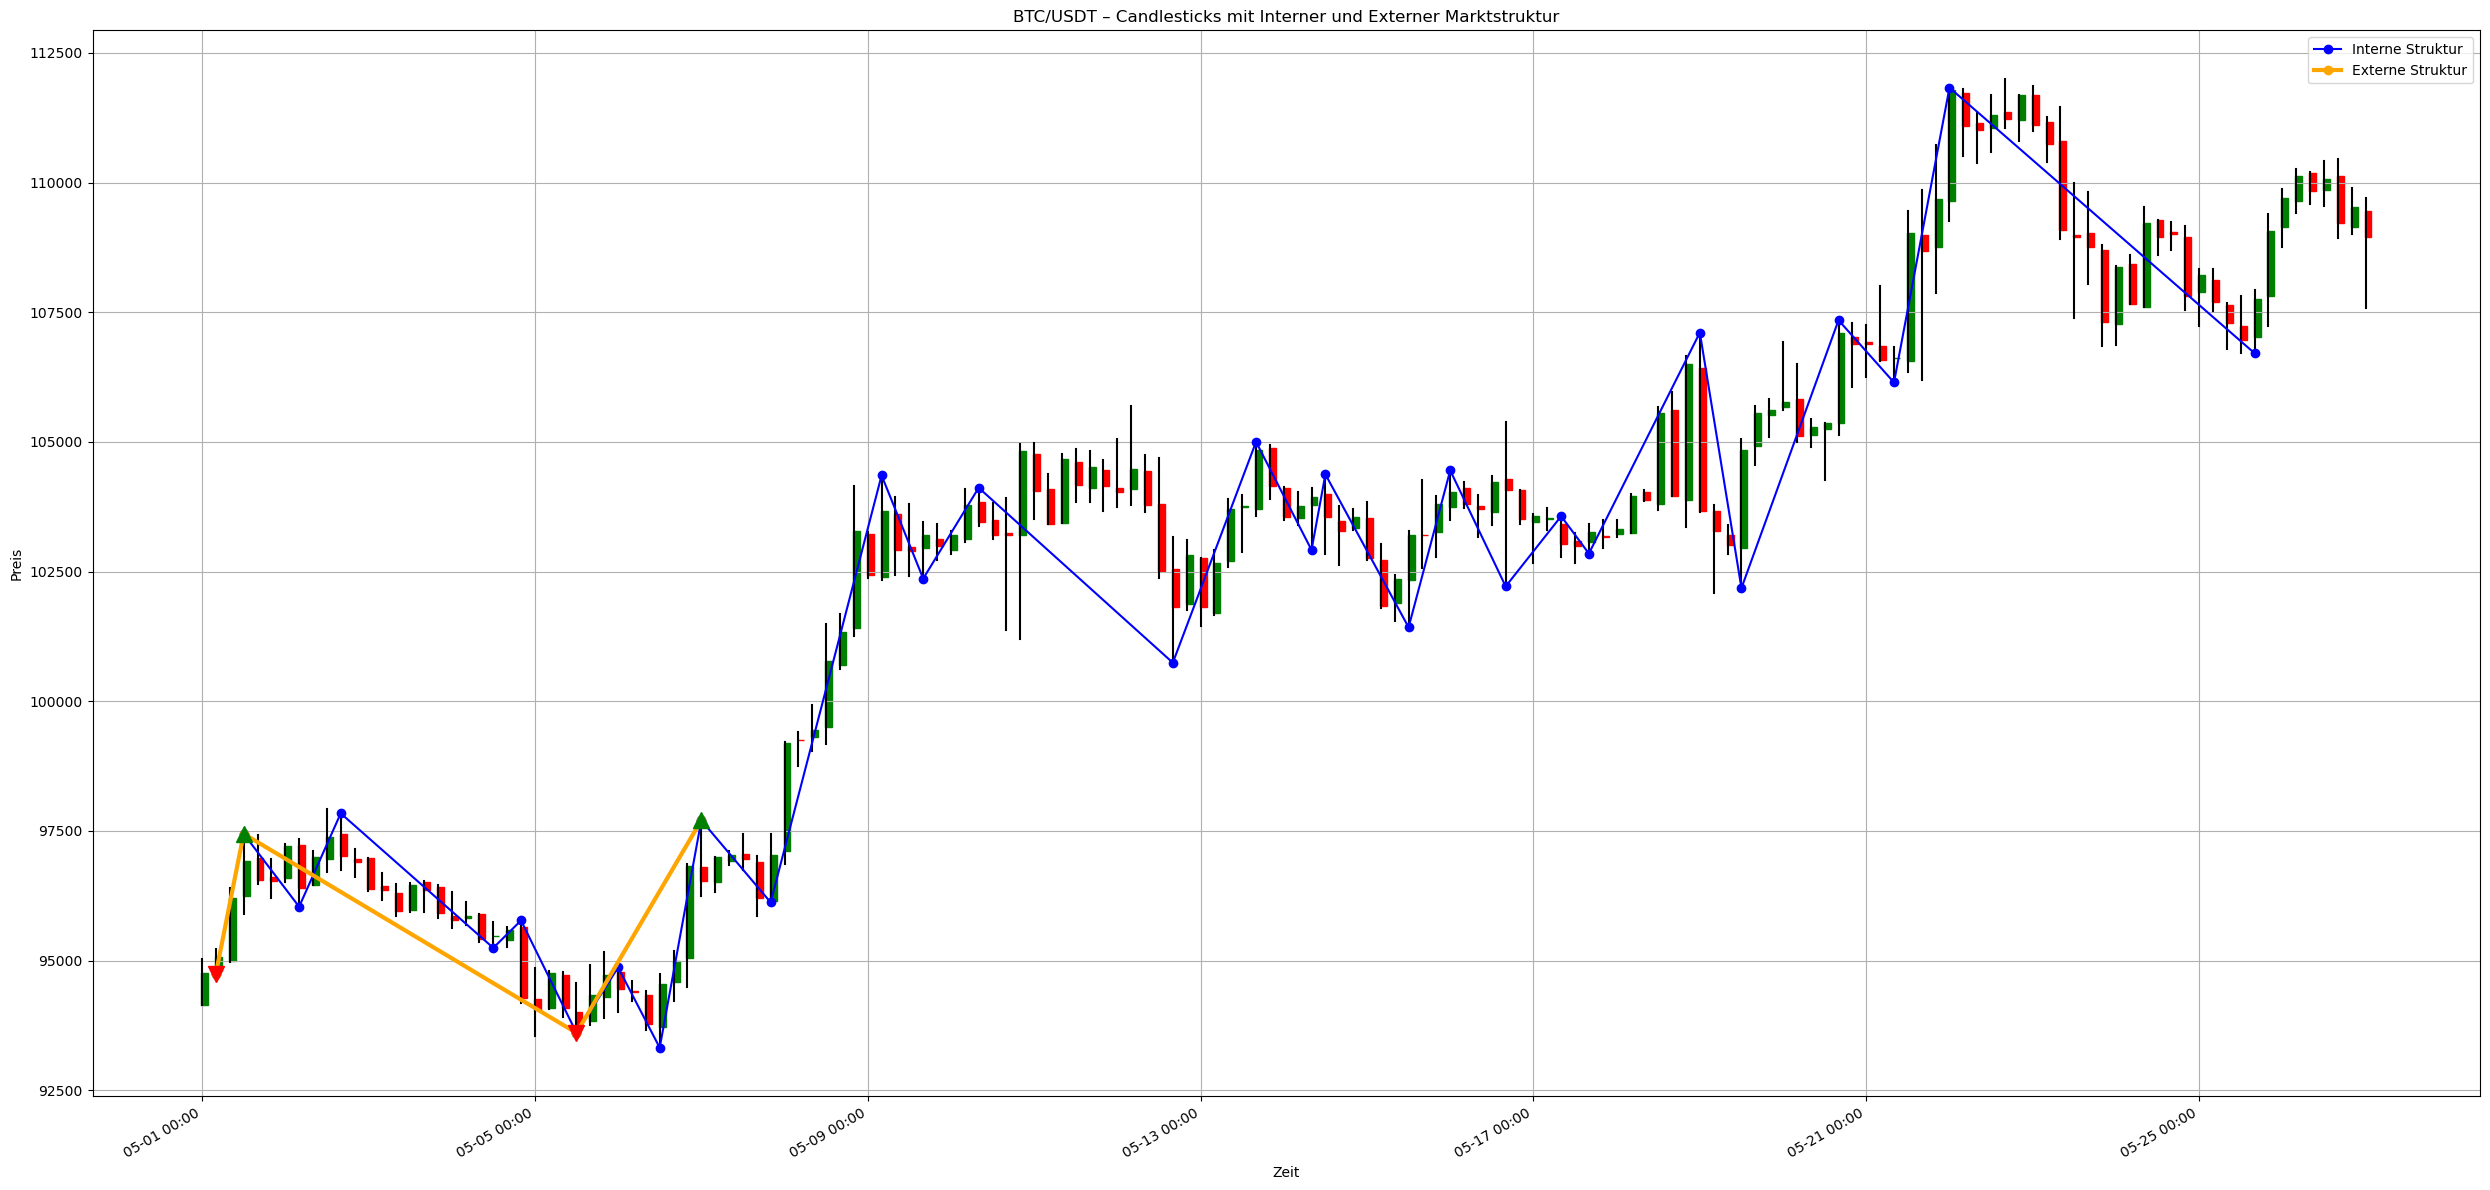

In [119]:
# Plot vorbereiten
fig, ax = plt.subplots(figsize=(25, 12))

# Breite der Kerze etwas kleiner als Intervall, um Abstand zu haben
candle_width = pd.Timedelta(minutes=120)  # wenn du 15-Minuten-Candles hast
# 1️⃣ Candlestick-Plot
for idx, row in btc_df.iterrows():
    color = 'green' if row['close'] >= row['open'] else 'red'
    lower = min(row['open'], row['close'])
    height = abs(row['close'] - row['open'])

    rect = mpatches.Rectangle(
        (row['timestamp'] - candle_width / 7, lower),
        candle_width,
        height,
        color=color
    )
    ax.add_patch(rect)
    ax.plot([row['timestamp'], row['timestamp']], [row['low'], row['high']], color='black')

# 2️⃣ Interne Strukturpunkte: feine Zickzack-Linie
internal_sorted = internal_df.sort_values('timestamp')
ax.plot(internal_sorted['timestamp'], internal_sorted['price'], linestyle='-', marker='o', color='blue', label='Interne Struktur')

# 3️⃣ Externe Strukturpunkte: dickere Linie
external_sorted = external_df.sort_values('timestamp')
ax.plot(external_sorted['timestamp'], external_sorted['price'], linestyle='-', marker='o', color='orange', linewidth=3, label='Externe Struktur')

# Strukturmarkierungen (Optional schönere Marker)
for _, row in external_sorted.iterrows():
    if row['type'] == 'External High':
        ax.plot(row['timestamp'], row['price'], marker='^', color='green', markersize=12)
    elif row['type'] == 'External Low':
        ax.plot(row['timestamp'], row['price'], marker='v', color='red', markersize=12)

# Formatierungen
ax.set_title('BTC/USDT – Candlesticks mit Interner und Externer Marktstruktur')
ax.set_xlabel('Zeit')
ax.set_ylabel('Preis')
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()